# Make Artificial Songs

In [1]:
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir
from starling_rhythm import synth

In [2]:
bID = 's_b1555_22'

In [3]:
bID_DIR = PROCESSED_DIR / bID
EMP_DIR = bID_DIR / 'templatingFalse-empiricalstrict'
QUA_DIR = bID_DIR / 'templatingTrue-transition_gap_profilesstrict'

In [4]:
emp_list = list(EMP_DIR.glob('*.wav'))
qua_list = list(QUA_DIR.glob('*.wav'))

In [5]:
emp_list.sort()

In [6]:
qua_list.sort()

## Dump into DataFrame

In [7]:
import pandas as pd
import numpy as np

In [8]:
n_jobs = 42
verbose = 0

In [9]:
emp_df = pd.DataFrame(
    {
        'file': emp_list,
        'type': np.full(len(emp_list), fill_value = 'empirical'),
        'dummy_id': np.arange(len(emp_list))
    }
)
qua_df = pd.DataFrame(
    {
        'file': qua_list,
        'type': np.full(len(qua_list), fill_value = 'quantized'),
        'dummy_id': np.arange(len(qua_list))
    }
)

stimuli_df = pd.concat([emp_df, qua_df])

## analyze length

In [10]:
from scipy.io.wavfile import read

In [11]:
srs = []
lengths = []

for file in stimuli_df['file']:
    sr, data = read(file)
    srs.append(sr)
    lengths.append(len(data))

In [12]:
stimuli_df['sr'] = srs
stimuli_df['length'] = lengths
stimuli_df['length_sec'] = stimuli_df['length'] / stimuli_df['sr']

In [13]:
stimuli_df = stimuli_df.reset_index(drop = True)

#### include pairs that contain more than 9 seconds

In [14]:
long_stimuli_df = []
for dummy_id in np.unique(stimuli_df['dummy_id']):
    pair = stimuli_df[stimuli_df['dummy_id'] == dummy_id]
    if min(pair.length_sec.values) >= 9:
        long_stimuli_df.append(pair)
        
long_stimuli_df = pd.concat(long_stimuli_df)

In [15]:
len(long_stimuli_df)

190

In [16]:
import seaborn as sns

<AxesSubplot:xlabel='length_sec', ylabel='Count'>

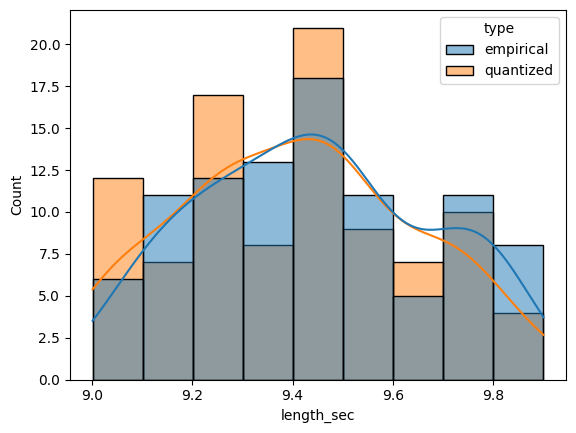

In [17]:
sns.histplot(data = long_stimuli_df, x = 'length_sec', hue = 'type', kde = True)

In [18]:
from scipy.stats import ks_2samp

In [19]:
ks_2samp(
    data1 = long_stimuli_df[long_stimuli_df['type'] == 'empirical'].length_sec.values,
    data2 = long_stimuli_df[long_stimuli_df['type'] == 'quantized'].length_sec.values,
    alternative = 'two_sided',
    method = 'auto'
)

KstestResult(statistic=0.10526315789473684, pvalue=0.6712813718081443)

Length is not statistically different across type

## analyze tMF

In [20]:
from starling_rhythm.mfdfa import tmf

/mnt/cube/j8xing/conda_envs/txori/starling_rhythm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [21]:
from joblib import Parallel, delayed
from tqdm.autonotebook import tqdm

In [22]:
import numpy as np

In [23]:
def tmf_n(
    address, 
    ns = 32, 
    amp_env_sr = 200,
    nt = 36
):
    SDoTMF = []
    for i in np.arange(0, nt):
        SDoTMF.append(tmf(address, ns = ns, amp_env_sr = amp_env_sr, hilbert_artifacts = True))
    
    return SDoTMF

In [24]:
%%time

with Parallel(n_jobs = n_jobs, verbose = verbose) as parallel:
    SDoTMF = parallel(
        delayed(tmf_n)(
            address,
            ns = 32,
            amp_env_sr = 200,
            nt = 100
        )
        for address in tqdm(long_stimuli_df.file.values, desc = 'shuffle')
    )

shuffle: 100%|██████████| 190/190 [1:29:45<00:00, 28.35s/it]


CPU times: user 1.06 s, sys: 605 ms, total: 1.67 s
Wall time: 2h 54min 52s


In [25]:
long_stimuli_df['SDoTMF'] = SDoTMF

In [26]:
long_stimuli_df['m_tmf'] = np.mean(SDoTMF, axis = 1)

In [27]:
long_stimuli_df

file       type  dummy_id  \
1    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         1   
151  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         1   
2    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         2   
152  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         2   
3    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         3   
..                                                 ...        ...       ...   
297  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       147   
148  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       148   
298  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       148   
149  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       149   
299  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       149   

        sr  length  length_sec  \
1    48000  467898    9.747875   
151  48000  465593    9.699854   
2    48000  454744    9.473833   
152  48000  455697    9.493688   
3    48000  447108    9.314750   
..     ...     ...         ...   
297  48000  453636    9.450750   
148  48000  438568    9.136833   
298  48000  441303    9.193812   
149  48000  449844    9.371750   
299  48000  447978    9.332875   

                                                SDoTMF      m_tmf  
1    [20.972248060194477, 17.808702760850327, 21.45...  21.512581  
151  [16.50072046390341, 19.32181986348796, 21.1585...  20.115673  
2    [15.85037494438224, 15.322809981413306, 19.039...  17.186969  
152  [15.477189575913698, 14.176225796366747, 12.55...  15.213141  
3    [9.768187636673126, 10.14542187768446, 10.0312...   9.728177  
..                                                 ...        ...  
297  [25.50472838375145, 26.41086292843144, 27.2436...  26.082039  
148  [26.56749671415955, 26.33522943542931, 31.8054...  26.528677  
298  [23.75876493308817, 27.77910510812, 16.4890902...  20.642130  
149  [36.968717498345775, 28.878519081758682, 42.28...  32.339434  
299  [29.92662191772715, 48.25924634311792, 34.1301...  39.991290  

[190 rows x 8 columns]

<AxesSubplot:xlabel='m_tmf', ylabel='Count'>

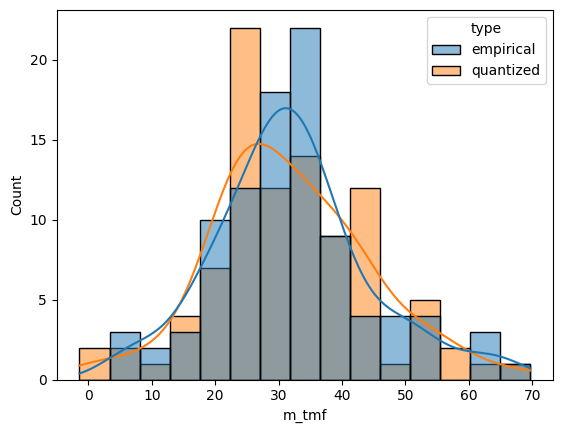

In [28]:
sns.histplot(data = long_stimuli_df, x = 'm_tmf', hue = 'type', kde = True)

In [29]:
ks_2samp(
    data1 = long_stimuli_df[long_stimuli_df['type'] == 'empirical'].m_tmf.values,
    data2 = long_stimuli_df[long_stimuli_df['type'] == 'quantized'].m_tmf.values,
    alternative = 'two_sided',
    method = 'auto'
)

KstestResult(statistic=0.11578947368421053, pvalue=0.5497554710458715)

In [30]:
dif_scores = []

for dummy_id in np.unique(long_stimuli_df['dummy_id']):
    pair = long_stimuli_df[long_stimuli_df['dummy_id'] == dummy_id]
    emp_tmf = pair[pair['type'] == 'empirical'].m_tmf.values[0]
    qua_tmf = pair[pair['type'] == 'quantized'].m_tmf.values[0]
    dif_scores.append(emp_tmf - qua_tmf)

<AxesSubplot:ylabel='Count'>

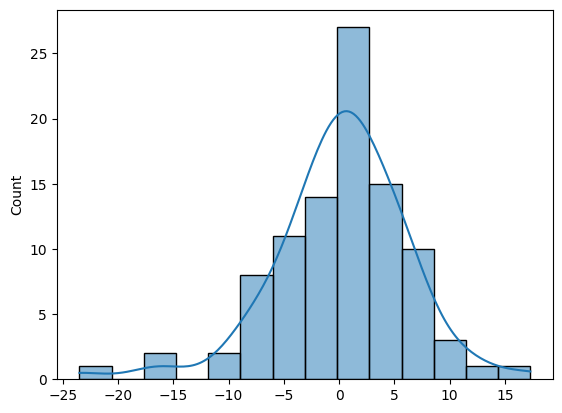

In [31]:
sns.histplot(data = dif_scores, kde = True)

In [32]:
import scipy.stats

In [33]:
scipy.stats.ttest_1samp(dif_scores, popmean = 0)

Ttest_1sampResult(statistic=0.30707508354099494, pvalue=0.7594654677237158)

## listen stimuli set

In [34]:
long_stimuli_df

file       type  dummy_id  \
1    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         1   
151  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         1   
2    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         2   
152  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         2   
3    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         3   
..                                                 ...        ...       ...   
297  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       147   
148  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       148   
298  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       148   
149  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       149   
299  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       149   

        sr  length  length_sec  \
1    48000  467898    9.747875   
151  48000  465593    9.699854   
2    48000  454744    9.473833   
152  48000  455697    9.493688   
3    48000  447108    9.314750   
..     ...     ...         ...   
297  48000  453636    9.450750   
148  48000  438568    9.136833   
298  48000  441303    9.193812   
149  48000  449844    9.371750   
299  48000  447978    9.332875   

                                                SDoTMF      m_tmf  
1    [20.972248060194477, 17.808702760850327, 21.45...  21.512581  
151  [16.50072046390341, 19.32181986348796, 21.1585...  20.115673  
2    [15.85037494438224, 15.322809981413306, 19.039...  17.186969  
152  [15.477189575913698, 14.176225796366747, 12.55...  15.213141  
3    [9.768187636673126, 10.14542187768446, 10.0312...   9.728177  
..                                                 ...        ...  
297  [25.50472838375145, 26.41086292843144, 27.2436...  26.082039  
148  [26.56749671415955, 26.33522943542931, 31.8054...  26.528677  
298  [23.75876493308817, 27.77910510812, 16.4890902...  20.642130  
149  [36.968717498345775, 28.878519081758682, 42.28...  32.339434  
299  [29.92662191772715, 48.25924634311792, 34.1301...  39.991290  

[190 rows x 8 columns]

In [35]:
select_df = long_stimuli_df[long_stimuli_df['dummy_id'] == 12]

In [36]:
select_df.file.values

array([PosixPath('/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_b1555_22/templatingFalse-empiricalstrict/s_b1555_22_2022-09-21_17-00-01-01_1451315_1473465_seg_5.0_15.0_templatingFalse-empiricalstrict_0_.wav'),
       PosixPath('/mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_b1555_22/templatingTrue-transition_gap_profilesstrict/s_b1555_22_2022-09-21_17-00-01-01_1451315_1473465_seg_5.0_15.0_templatingTrue-transition_gap_profilesstrict_0_.wav')],
      dtype=object)

In [37]:
import matplotlib.pyplot as plt

/mnt/cube/j8xing/conda_envs/txori/starling_rhythm/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


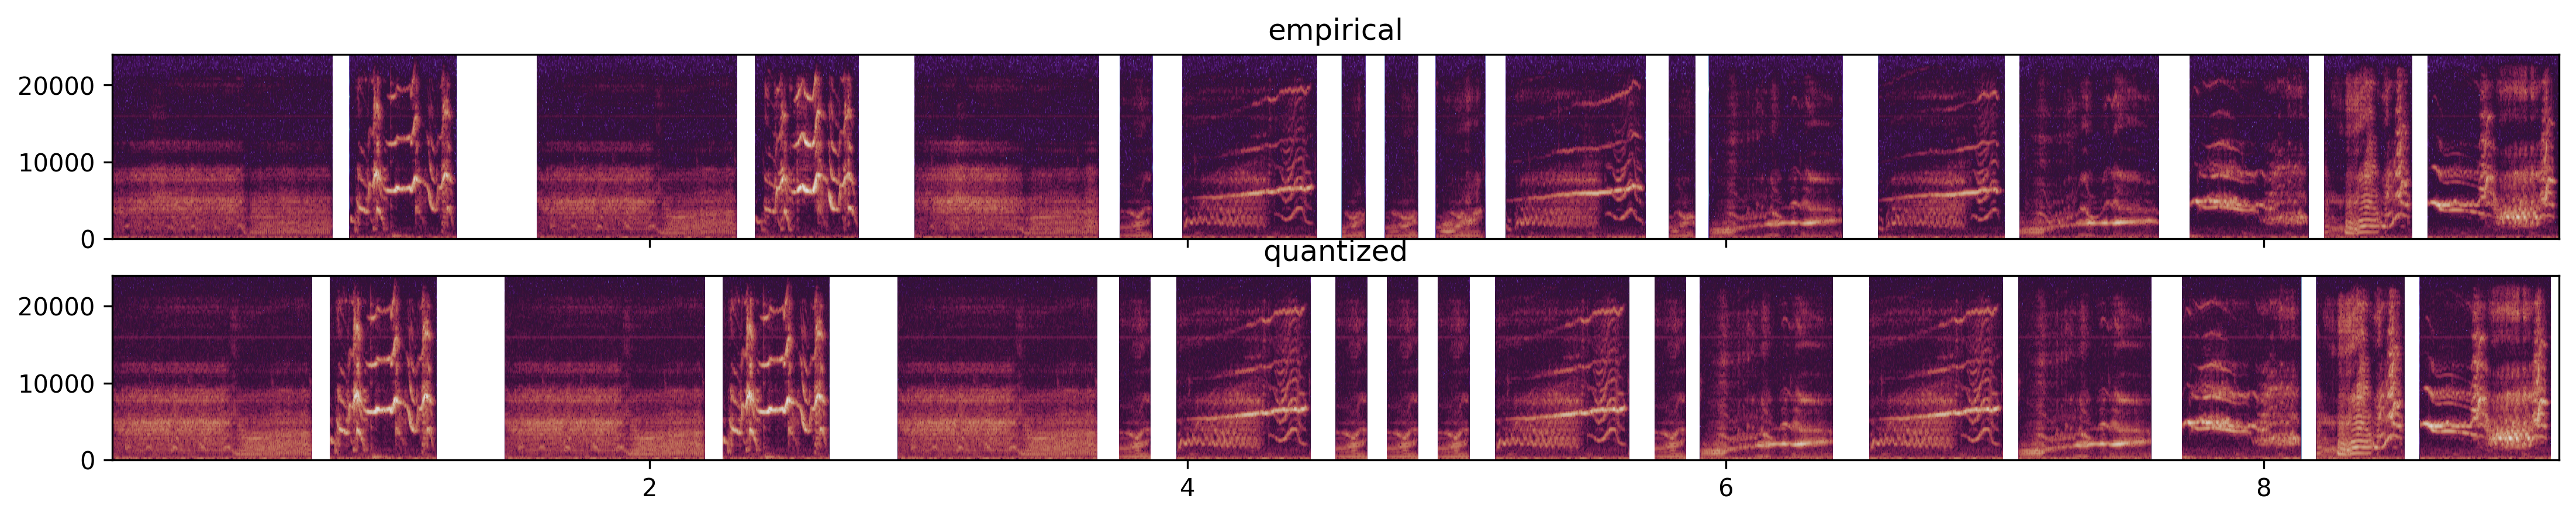

In [38]:
fig, axs = plt.subplots(2, sharex = True, figsize=(18, 3), dpi=300)
axs[0].title.set_text('empirical')
emp_sr, emp_data = read(select_df[select_df['type'] == 'empirical'].file.values[0])
x = axs[0].specgram(emp_data, Fs = emp_sr, cmap = 'twilight')
qua_sr, qua_data = read(select_df[select_df['type'] == 'quantized'].file.values[0])
axs[1].title.set_text('quantized')
y = axs[1].specgram(qua_data, Fs = 48000, cmap = 'twilight')

In [39]:
import IPython

In [40]:
IPython.display.display(IPython.display.Audio(str(select_df.file.values[0])))
IPython.display.display(IPython.display.Audio(str(select_df.file.values[1])))

## split into training and test set

In [41]:
## dump all dummy_ids into a marble jar
marble_jar = list(np.unique(long_stimuli_df.dummy_id.values))

In [42]:
import random

In [43]:
random.seed(a = 15606721)
## grab a training set of 64 pairs
training_set = random.sample(population = marble_jar, k = 64)
## the rest are test sets
test_set = [dummy_id for dummy_id in marble_jar if dummy_id not in set(training_set)]

## make sure they don't overlap
assert set(training_set).isdisjoint(set(test_set)) == True

In [44]:
training_df = long_stimuli_df[long_stimuli_df['dummy_id'].isin(training_set)]
training_df['designation'] = np.full(len(training_df), 'training')

## give config ids
config_id = []
for dummy_id, i in zip(np.unique(training_df['dummy_id'].values), np.arange(len(np.unique(training_df['dummy_id'].values)))):
    pair = training_df[training_df['dummy_id'] == dummy_id]
    pair['config_id'] = i
    config_id.append(pair)
training_df = pd.concat(config_id)

test_df = long_stimuli_df[long_stimuli_df['dummy_id'].isin(test_set)]
test_df['designation'] = np.full(len(test_df), 'test')

## give config ids
config_id = []
for dummy_id, i in zip(np.unique(test_df['dummy_id'].values), np.arange(len(np.unique(test_df['dummy_id'].values)))):
    pair = test_df[test_df['dummy_id'] == dummy_id]
    pair['config_id'] = i
    config_id.append(pair)
test_df = pd.concat(config_id)

split_stimuli_df = pd.concat([training_df, test_df])

/tmp/ipykernel_38587/2796505090.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_df['designation'] = np.full(len(training_df), 'training')
/tmp/ipykernel_38587/2796505090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair['config_id'] = i
/tmp/ipykernel_38587/2796505090.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [45]:
split_stimuli_df

file       type  dummy_id  \
1    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         1   
151  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         1   
2    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         2   
152  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         2   
3    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         3   
..                                                 ...        ...       ...   
290  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       140   
144  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       144   
294  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       144   
148  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       148   
298  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       148   

        sr  length  length_sec  \
1    48000  467898    9.747875   
151  48000  465593    9.699854   
2    48000  454744    9.473833   
152  48000  455697    9.493688   
3    48000  447108    9.314750   
..     ...     ...         ...   
290  48000  432760    9.015833   
144  48000  454167    9.461813   
294  48000  449937    9.373688   
148  48000  438568    9.136833   
298  48000  441303    9.193812   

                                                SDoTMF      m_tmf designation  \
1    [20.972248060194477, 17.808702760850327, 21.45...  21.512581    training   
151  [16.50072046390341, 19.32181986348796, 21.1585...  20.115673    training   
2    [15.85037494438224, 15.322809981413306, 19.039...  17.186969    training   
152  [15.477189575913698, 14.176225796366747, 12.55...  15.213141    training   
3    [9.768187636673126, 10.14542187768446, 10.0312...   9.728177    training   
..                                                 ...        ...         ...   
290  [40.234780570428676, 39.07790921604962, 43.941...  44.138392        test   
144  [27.552771945331326, 30.231296140308544, 35.33...  30.002595        test   
294  [19.680564104234886, 24.785935898147308, 24.13...  23.765991        test   
148  [26.56749671415955, 26.33522943542931, 31.8054...  26.528677        test   
298  [23.75876493308817, 27.77910510812, 16.4890902...  20.642130        test   

     config_id  
1            0  
151          0  
2            1  
152          1  
3            2  
..         ...  
290         28  
144         29  
294         29  
148         30  
298         30  

[190 rows x 10 columns]

In [46]:
import shutil

In [47]:
## copy over files, save stim name and path in the process

stim_name = []
stim_path = []

for index, row in split_stimuli_df.iterrows():
    
    filename = row['type'] + '_' + str(row['config_id']) + '_' + row['designation'] + '.wav'
    stim_name.append(filename)
    
    source = row['file']
    destination = PROCESSED_DIR / bID / 'quant_stimuli' / filename
    
    ensure_dir(destination)
    
    ## copy files 
    shutil.copyfile(source, destination)
    
    stim_path.append(destination)
    
split_stimuli_df['stim_name'] = stim_name
split_stimuli_df['stim_path'] = stim_path

In [48]:
split_stimuli_df

file       type  dummy_id  \
1    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         1   
151  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         1   
2    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         2   
152  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized         2   
3    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical         3   
..                                                 ...        ...       ...   
290  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       140   
144  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       144   
294  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       144   
148  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  empirical       148   
298  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  quantized       148   

        sr  length  length_sec  \
1    48000  467898    9.747875   
151  48000  465593    9.699854   
2    48000  454744    9.473833   
152  48000  455697    9.493688   
3    48000  447108    9.314750   
..     ...     ...         ...   
290  48000  432760    9.015833   
144  48000  454167    9.461813   
294  48000  449937    9.373688   
148  48000  438568    9.136833   
298  48000  441303    9.193812   

                                                SDoTMF      m_tmf designation  \
1    [20.972248060194477, 17.808702760850327, 21.45...  21.512581    training   
151  [16.50072046390341, 19.32181986348796, 21.1585...  20.115673    training   
2    [15.85037494438224, 15.322809981413306, 19.039...  17.186969    training   
152  [15.477189575913698, 14.176225796366747, 12.55...  15.213141    training   
3    [9.768187636673126, 10.14542187768446, 10.0312...   9.728177    training   
..                                                 ...        ...         ...   
290  [40.234780570428676, 39.07790921604962, 43.941...  44.138392        test   
144  [27.552771945331326, 30.231296140308544, 35.33...  30.002595        test   
294  [19.680564104234886, 24.785935898147308, 24.13...  23.765991        test   
148  [26.56749671415955, 26.33522943542931, 31.8054...  26.528677        test   
298  [23.75876493308817, 27.77910510812, 16.4890902...  20.642130        test   

     config_id                 stim_name  \
1            0  empirical_0_training.wav   
151          0  quantized_0_training.wav   
2            1  empirical_1_training.wav   
152          1  quantized_1_training.wav   
3            2  empirical_2_training.wav   
..         ...                       ...   
290         28     quantized_28_test.wav   
144         29     empirical_29_test.wav   
294         29     quantized_29_test.wav   
148         30     empirical_30_test.wav   
298         30     quantized_30_test.wav   

                                             stim_path  
1    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
151  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
2    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
152  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
3    /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
..                                                 ...  
290  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
144  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
294  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
148  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  
298  /mnt/cube/j8xing/starling_rhythm_mfdfa/data/s_...  

[190 rows x 12 columns]

In [49]:
## Pickle
from starling_rhythm.utils.paths import PROCESSED_DIR, ensure_dir
SAVE_PATH = PROCESSED_DIR / bID / 'quant_stimuli.pickle'
ensure_dir(SAVE_PATH)
split_stimuli_df.to_pickle(SAVE_PATH)